# Simulation using Devito with single elastic domain on staggered grid

### Note: this notebook has been tested within the docker only. It it needs to be run outside of the docker, the user must install Devito beforehand (https://github.com/devitocodes/devito).

Devito implementation follows the method described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

In [1]:
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import SeismicModel, plot_image, demo_model
import numpy as np
from scipy import signal
from scipy import ndimage
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

In [2]:
# Create directories to store data and figures
!mkdir -p ../dat ../fig

In [3]:
# Model grid: 6000 m x 4080 m, with spacing 5 m
xmax=6000.
zmax=4080. + 1000.
dx=5.
dz=5.
nx=1201
nz=817 + 200
nza=240

sx=2400.
sz=1120
rx=3440
rz=1200

extent = (xmax, zmax)
shape = (nx, nz)
spacing= (dx,dz)

# full model (acoustic on top then elastic)
aemodel=np.zeros((3,nx,nz))

vpa=1.5
vsa=0.
rhoa=1.
vpe=3.
vse=1.
rhoe=2.5

ka=rhoa*vpa**2
mua=0.
mue=rhoe*vse**2
ke=rhoe*vpe**2-4./3.*mue

kavg=2./(1./ka + 1./ke)
muavg=0.
rhoavg=0.5*(rhoa+rhoe)

vpavg=math.sqrt((kavg+4./3.*muavg)/rhoavg)
vsavg=math.sqrt(muavg/rhoavg)

# elastic layer
aemodel[0,:,:]=vpe # Vp in km/s
aemodel[1,:,:]=vse # Vs in km/s
aemodel[2,:,:]=rhoe # Density in g/cc

# # acoustic layer
aemodel[0,:,:nza]=vpa
aemodel[1,:,:nza]=vsa
aemodel[2,:,:nza]=rhoa

# # values at the interface same as the fluid
aemodel[0,:,nza]=vpa
aemodel[1,:,nza]=vsa
aemodel[2,:,nza]=rhoa

mu = aemodel[2,:,:] * aemodel[1,:,:]*aemodel[1,:,:]
lam = aemodel[2,:,:] * aemodel[0,:,:]*aemodel[0,:,:] - 2*mu
b = 1/aemodel[2,:,:]

so = 4
to = 2

origin=(0.,0.)
nbl=0
model = SeismicModel(origin=origin, vp=aemodel[0,:,:], vs=aemodel[1,:,:], b=b,shape=shape, spacing=spacing, space_order=so, nbl=0)

Operator `pad_lam` ran in 0.01 s
Operator `pad_mu` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


In [4]:
# Source wavelet (derivative of Ricker)
nt=5001
dt=0.5 # ms
#dt=model.critical_dt
ot=0.

# create dummy source
t0, tn = ot, (nt-1)*dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)
src = RickerSource(name='src', grid=model.grid, f0=0.015, time_range=time_range)

# create the actual source and replace the dummy one
wc=0.01
sigma=math.sqrt(2)/(math.pi*wc)
src1 = signal.ricker(2*nt-1, sigma)
src1=src1[4750:4750+nt]
src1=src1*1.0/np.max(src1)
# divide by 25 (element surface to account for delta function) 
# and multiply by 1.5^2 (velocity squared)
# Additional factor of 1000 is needed (ms vs sec)
# this is needed to compare with SBP-SAT which solves the second order potential equation
src1=src1*1000*vpa**2/(dx*dz)
src.data[:,0] = src1[:]

# source location in meters
src.coordinates.data[:] = [sx, sz]

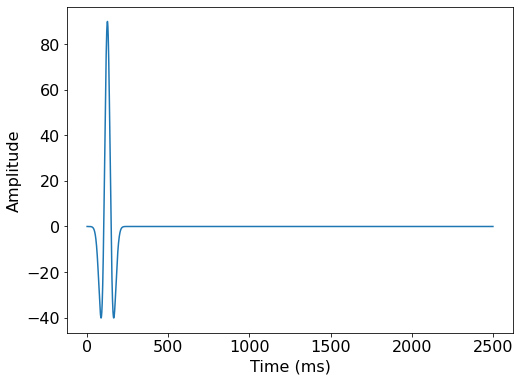

In [5]:
plt.plot(np.linspace(ot,(nt-1)*dt,nt),src.data[:,0])
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

In [6]:
x, z = model.grid.dimensions
t = model.grid.stepping_dim
time = model.grid.time_dim
s = time.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

In [7]:
# define the free surface
def freesurface_top(tau, v, model):
    time = model.grid.stepping_dim
    pos = int(max(tau.space_order, v.space_order)/2)
    
    bc_tau1 = [Eq(tau[0,0][time+1, x, 0], 0.) ]
    bc_tau2 = [Eq(tau[1,1][time+1, x, 0], 0.) ]
    
    return  bc_tau1 + bc_tau2

bc = freesurface_top(tau, v, model)

In [8]:
# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=dt*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=dt*src)

# The receiver
nrec = 1
rec1 = Receiver(name="rec1", grid=model.grid, npoint=nrec, time_range=time_range)
rec1.coordinates.data[0, 0] = rx
rec1.coordinates.data[0, 1] = rz

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[0, 0] = rx
rec2.coordinates.data[0, 1] = rz

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[0, 0] = rx
rec3.coordinates.data[0, 1] = rz

rec_term = rec1.interpolate(expr=tau[0, 0]) # xx component of the stress tensor (= - pressure)
rec_term += rec2.interpolate(expr=v[0]) # horizontal particle velocity
rec_term += rec3.interpolate(expr=v[1]) # vertical particle velocity

In [9]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).T)
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] + bc + src_xx + src_zz + rec_term)

In [10]:
op.apply(dt=dt)
#op.apply(dt=dt, time_M=1000)

Operator `Kernel` ran in 29.18 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=28.21787900000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.34123999999999677, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.23505300000000828, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.22528900000000798, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section4', rank=None),
  PerfEntry(time=0.1536750000000062, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [11]:
# save to numpy
allrec=np.zeros((3,nt))
allrec[0] = -np.transpose(rec1.data)
allrec[1] = np.transpose(rec2.data)
allrec[2] = np.transpose(rec3.data)
np.save('../dat/devito2',allrec)